In [1]:
%matplotlib inline

In [2]:
from grid.gmt import GMTGrid
from grid.shake import ShakeGrid
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os.path
import matplotlib

The Grid class hierarchy can be used for reading, writing and manipulating various kinds 
of 2D grid formats (GMT grids), or multi-layer 2D grid formats (ShakeMap).

In [3]:
#######MODIFY THIS TO REFLECT THE LOCATION OF A GLOBAL GRID ON YOUR SYSTEM####
popfile = os.path.join(os.path.expanduser('~'),'pager','data','lspop2012.grd')
vs30file = os.path.join(os.path.expanduser('~'),'secondary','data','global_vs30.grd')
shakefile = os.path.join(os.path.expanduser('~'),'data','shakemaps','nepal2011.xml')
##############################################################################

The grid classes can be used to get spatial information about the file before opening it. 

In [4]:
fgeodict = GMTGrid.getFileGeoDict(vs30file)
bounds = (fgeodict['xmin'],fgeodict['xmax'],fgeodict['ymin'],fgeodict['ymax'])
print 'The file spans from %.3f to %.3f in longitude, and %.3f to %.3f in latitude.' % bounds

The file spans from -180.000 to 180.000 in longitude, and -56.000 to 84.000 in latitude.


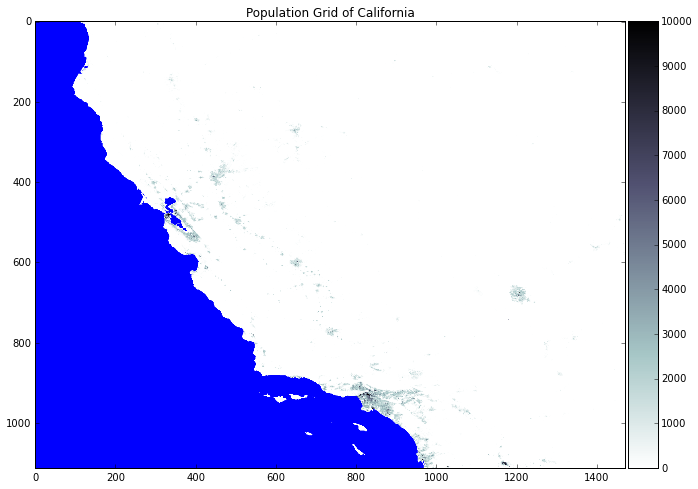

In [5]:
#41.798959,-125.178223 ulcorner of calif
#32.543919,-112.950439 lrcorner of calif
sdict = {'xmin':-125.178223,'xmax':-112.950439,'ymin':32.543919,'ymax':41.798959,'xdim':0.008,'ydim':0.008}
grid = GMTGrid.load(popfile,samplegeodict=sdict)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8));
data = grid.getData().copy()
data[data == -9999] = np.nan
data = np.ma.array (data, mask=np.isnan(data))
cmap = matplotlib.cm.bone_r
cmap.set_bad('b',1.)
im = plt.imshow(data,cmap=cmap,vmin=0,vmax=10000)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05);
plt.colorbar(im, cax=cax);
ax.set_title('Population Grid of California');

Let's test reading across the 180/-180 meridian

175.883238038 181.566702933 -18.6049140284 -14.996407874


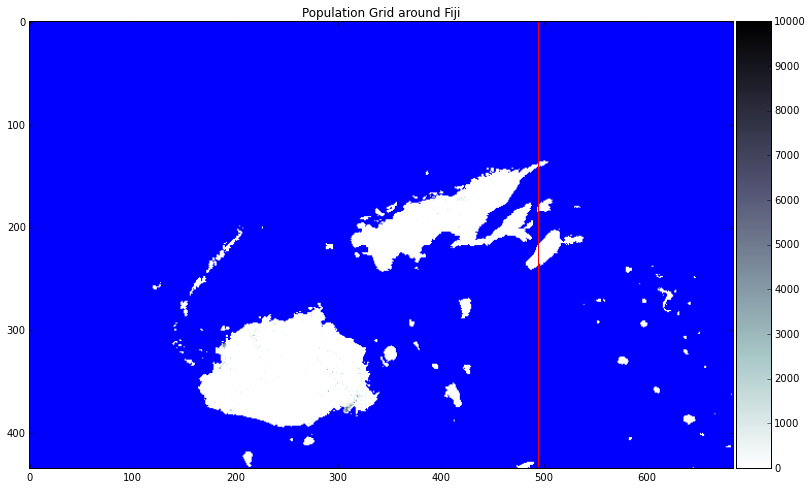

In [6]:
#LL: -18.606228,175.891113
#UR: -14.990556,-178.439941
sdict = {'xmin':175.891113,'xmax':-178.439941,'ymin':-18.606228,'ymax':-14.990556}
grid = GMTGrid.load(popfile,samplegeodict=sdict)
xmin,xmax,ymin,ymax = grid.getBounds()
print xmin,xmax,ymin,ymax
m1y,m1x = grid.getRowCol(ymin,180.0)
m2y,m2x = grid.getRowCol(ymax,180.0)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8));
data = grid.getData().copy()
data[data == -9999] = np.nan
data = np.ma.array (data, mask=np.isnan(data))
cmap = matplotlib.cm.bone_r
cmap.set_bad('b',1.)
im = plt.imshow(data,cmap=cmap,vmin=0,vmax=10000)
axlim = plt.axis()
plt.hold(True)
plt.plot([m1x,m2x],[m1y,m2y],'r')
plt.axis(axlim)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05);
plt.colorbar(im, cax=cax);
ax.set_title('Population Grid around Fiji');

Let's use a ShakeMap grid to cut out a piece of the population grid, then resample the ShakeMap to the population data.

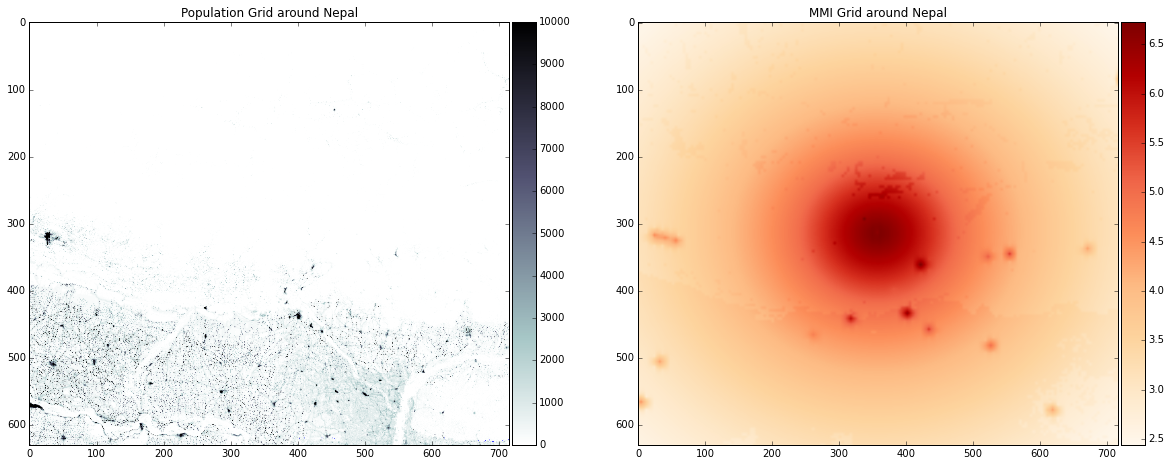

In [7]:
# grid._data = np.array([])
# del grid
fdict = ShakeGrid.getFileGeoDict(shakefile) #get the bounds of the ShakeMap
newdict = GMTGrid.getBoundsWithin(popfile,fdict) #get some bounds guaranteed to be inside the ShakeMap
shake = ShakeGrid.load(shakefile) #load the ShakeMap
popgrid = GMTGrid.load(popfile,samplegeodict=newdict) #load without any resampling or anything
xmin,xmax,ymin,ymax = popgrid.getBounds()
shake.interpolateToGrid(popgrid.getGeoDict())
popdict = popgrid.getGeoDict()
shakedict = shake.getGeoDict()
popdata = popgrid.getData().copy()
mmidata = shake.getLayer('mmi').getData()
popdata[popdata == -9999] = np.nan
popdata = np.ma.array(popdata, mask=np.isnan(popdata))
fig,axeslist = plt.subplots(nrows=1,ncols=2,figsize=(20,16))


#plot population
m1y,m1x = popgrid.getRowCol(ymin,180.0)
m2y,m2x = popgrid.getRowCol(ymax,180.0)
plt.sca(axeslist[0])
cmap = matplotlib.cm.bone_r
im = plt.imshow(popdata,cmap=cmap,vmin=0,vmax=10000)
axlim = plt.axis()
plt.hold(True)
plt.plot([m1x,m2x],[m1y,m2y],'r')
plt.axis(axlim)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(axeslist[0])
cax1 = divider.append_axes("right", size="5%", pad=0.05);
plt.colorbar(im, cax=cax1);
axeslist[0].set_title('Population Grid around Nepal');

#plot pga
plt.sca(axeslist[1]);
cmap = matplotlib.cm.OrRd
im = plt.imshow(mmidata,cmap=cmap)
axlim = plt.axis()
plt.hold(True)
plt.plot([m1x,m2x],[m1y,m2y],'r')
plt.axis(axlim)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(axeslist[1])
cax2 = divider.append_axes("right", size="5%", pad=0.05);
plt.colorbar(im, cax=cax2);
axeslist[1].set_title('MMI Grid around Nepal');

Implement the PAGER exposure algorithm.

In [14]:
if np.any(mmidata > 9):
    mmidata[mmidata > 9.0] = 9.0
expolist = np.zeros((5))
for mmi in range(5,10):
    immi = (mmidata > mmi-0.5) & (mmidata <= mmi+0.5)
    expolist[mmi-5] = np.sum(popdata[immi])
print expolist

[ 7477055.  1568541.     9755.       nan       nan]
